In [1]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

#load np arrays in pytorch tensors and dataloaders
data = np.load('./data/egamma_norm.npz')

#split into train (90%) /valid (10%) set
seed = 123
X_train, X_valid, y_train, y_valid = train_test_split(data['X_train'], data['y_train'], test_size=0.1, stratify=data['y_train'], random_state=seed)

X_test, y_test = data['X_test'], data['y_test']

# X_train = normalize(X_train, 'train')
# X_valid = normalize(X_valid, 'valid')
# X_test = normalize(X_test, 'test')

train_x, train_y = torch.Tensor(X_train).permute(0, 3, 1, 2), torch.Tensor(y_train).unsqueeze(1)
valid_x, valid_y = torch.Tensor(X_valid).permute(0, 3, 1, 2), torch.Tensor(y_valid).unsqueeze(1)
test_x, test_y = torch.Tensor(X_test).permute(0, 3, 1, 2), torch.Tensor(y_test).unsqueeze(1)

train_set = TensorDataset(train_x, train_y)
valid_set = TensorDataset(valid_x, valid_y)
test_set = TensorDataset(test_x, test_y)

#load tensors into dataloaders
batch_size = 64
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
valid_dl = DataLoader(valid_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

In [2]:
#find gpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

metric_logger = {}
for label in ['Train', 'Test', 'Valid', 'Trainb']:
    metric_logger['Accuracy/'+label] = []
    metric_logger['AUC/'+label] = []
    metric_logger['Loss/'+label] = []

#testing function
def evaluate_metrics(model, dl, epoch, label="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    outputs, targets = [], []
    with torch.no_grad():
        for data, target in dl:
            
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            #compute sum of loss
            test_loss += F.binary_cross_entropy_with_logits(output, target, reduction='sum')
            
            #save predictions for computation of auc
            outputs += output.flatten().tolist()
            targets += target.flatten().tolist()
            
            #compute # of correct prediction
            pred = (output>0.5)
            correct += (pred==target.to(torch.bool)).sum()
        
        #compute average loss, accuracy and auc
        test_loss /= len(dl.dataset)
        test_accuracy = correct / len(dl.dataset)
        auc = roc_auc_score(targets, outputs)
        
    print('\n{} Epoch: {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), AUC :{}\n'.format(
        epoch,
        label,
        test_loss, 
        correct, len(dl.dataset),
        100. * test_accuracy, auc))
    
    metric_logger['Accuracy/'+label].append(test_accuracy.item())
    metric_logger['Loss/'+label].append(test_loss)
    metric_logger['AUC/'+label].append(auc)
    
    return auc

In [4]:
import time
import random
import torchvision.transforms as transforms

log_interval = 1000

#training function
def runTrain(model, dl, epoch, optimizer):
    model.train()
    counter = 0
    tik = time.time()
    for batch_idx, (data, target) in enumerate(dl):
        sys.stdout.flush()

        optimizer.zero_grad(set_to_none=True)
        
        data, target = data.to(device), target.to(device)
                
        #add data aug with random flips/rotations
        h_flip_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], ), device=device))
        data[h_flip_rand] = data[h_flip_rand].flip(2+1)

        v_flip_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], ), device=device))
        data[v_flip_rand] = data[v_flip_rand].flip(3+1)

        rotate_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], ), device=device))
        
        for to_rotate in rotate_rand:
            data[to_rotate] = transforms.functional.rotate(data[to_rotate], random.random()*360)#, fill=(-0.00115032/0.02362085, 0.0002377/0.06677763)) 

        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target)
        
        loss.backward()
        optimizer.step()
        
        pred = (output>0.5)
        correct = (pred==target.to(torch.bool)).sum()
        
        train_accuracy = correct / len(data)
        
        counter+=len(data)
        
        if batch_idx % log_interval == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}, Batch Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, counter, len(dl.dataset),
            100. * batch_idx / len(dl), loss.item(), 
            correct, len(data), 100. * train_accuracy))
            print('Time taken: {}'.format(time.time() - tik))
            tik = time.time()

In [5]:
from ViT import ViT
from torchinfo import summary

model = ViT(img_size=(32, 32), patch_size=(4, 4), num_hiddens=48, mlp_num_hiddens=96,
           num_heads=4, num_blks=8, blk_dropout=0.1, use_cls=False, use_bias=False)

#Check network struct
summary(model, (64, 2, 32, 32), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
ViT                                      [64, 1]                   3,120
├─PatchEmbedding: 1-1                    [64, 64, 48]              --
│    └─Conv2d: 2-1                       [64, 48, 8, 8]            1,584
├─Sequential: 1-2                        [64, 64, 48]              --
│    └─ViTBlock: 2-2                     [64, 64, 48]              --
│    │    └─LayerNorm: 3-1               [64, 64, 48]              96
│    │    └─MultiheadAttention: 3-2      [64, 64, 48]              9,216
│    │    └─LayerNorm: 3-3               [64, 64, 48]              96
│    │    └─Sequential: 3-4              [64, 64, 48]              9,360
│    └─ViTBlock: 2-3                     [64, 64, 48]              --
│    │    └─LayerNorm: 3-5               [64, 64, 48]              96
│    │    └─MultiheadAttention: 3-6      [64, 64, 48]              9,216
│    │    └─LayerNorm: 3-7               [64, 64, 48]              96


In [ ]:
import torch.optim as optim
import pickle

import sys
sys.stdout = open("logs/my_log.txt", "a")

n_epochs = 500

model = model.to(device)

#define optimizer
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=10, verbose=True)

#list to apply early stopping if valid auc stopped improving
auc_cur, best_auc = -999, -999
stopping_epochs, stopping_epochs_counter = 10, 0

#run train and test
for epoch in range(1, n_epochs + 1):
    runTrain(model, train_dl, epoch, optimizer)
    
    #check testing set metrics
    evaluate_metrics(model, test_dl, epoch)
    
    #check training set metrics
    evaluate_metrics(model, train_dl, epoch, 'Train')
        
    #check valid set metrics
    auc_cur = evaluate_metrics(model, valid_dl, epoch, 'Valid')
        
    #reduce lr
    scheduler.step(auc_cur)      
    
    torch.save(model, f"models/task3_model.pt")
    
    with open('logs/metrics.pickle', 'wb') as handle:
        pickle.dump(metric_logger, handle)
  
    #do early stopping
#     if auc_cur > best_auc:
#         best_auc = auc_cur
#         stopping_epochs_counter = 0
#     else:
#         stopping_epochs_counter += 1
        
#     if stopping_epochs_counter >= stopping_epochs: 
#         print('----------early breaking----------')
#         break

In [1]:
!cat logs/my_log.txt

Train Epoch: 1 [64/358164 (0%)]	Batch Loss: 0.711645, Batch Accuracy: 30/64 (47%)

Time taken: 0.8192036151885986
Train Epoch: 1 [64064/358164 (18%)]	Batch Loss: 0.720333, Batch Accuracy: 33/64 (52%)

Time taken: 30.465044260025024
Train Epoch: 1 [128064/358164 (36%)]	Batch Loss: 0.657024, Batch Accuracy: 36/64 (56%)

Time taken: 31.092247009277344
Train Epoch: 1 [192064/358164 (54%)]	Batch Loss: 0.691492, Batch Accuracy: 25/64 (39%)

Time taken: 30.198284149169922
Train Epoch: 1 [256064/358164 (71%)]	Batch Loss: 0.658244, Batch Accuracy: 31/64 (48%)

Time taken: 34.10804843902588
Train Epoch: 1 [320064/358164 (89%)]	Batch Loss: 0.694324, Batch Accuracy: 36/64 (56%)

Time taken: 30.4621365070343

1 Epoch: Test: Avg. loss: 0.6632, Accuracy: 53206/99490 (53%), AUC :0.6512723986494582


1 Epoch: Train: Avg. loss: 0.6632, Accuracy: 191609/358164 (53%), AUC :0.6513760589444444


1 Epoch: Valid: Avg. loss: 0.6623, Accuracy: 21327/39796 (54%), AUC :0.6535819420986864

Train Epoch: 2 [64/35816

Loss
Number of Epochs 265: Testing 0.5341, Training 0.5223, Valid 0.5313
Accuracy
Number of Epochs 265: Testing 0.7206, Training 0.7304, Valid 0.7242
AUC
Number of Epochs 265: Testing 0.8078, Training 0.8178, Valid 0.8106
Best Test AUC achieved at Epoch 220: 0.8079
Test AUC achieved at last Epoch: 0.8078


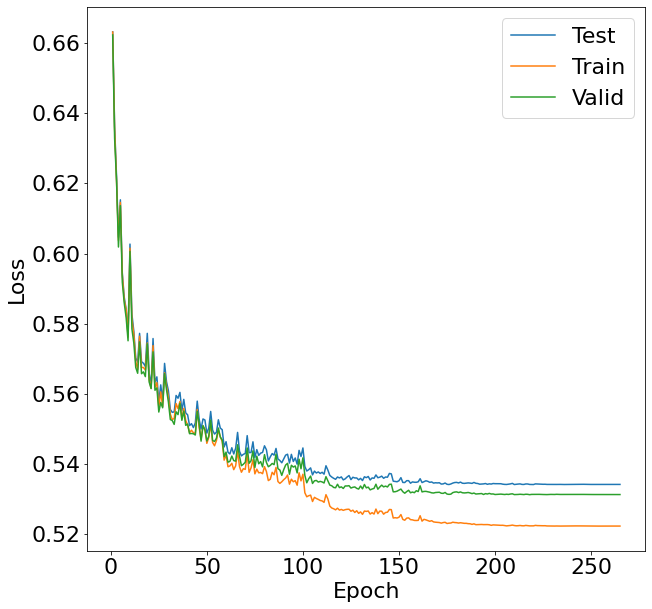

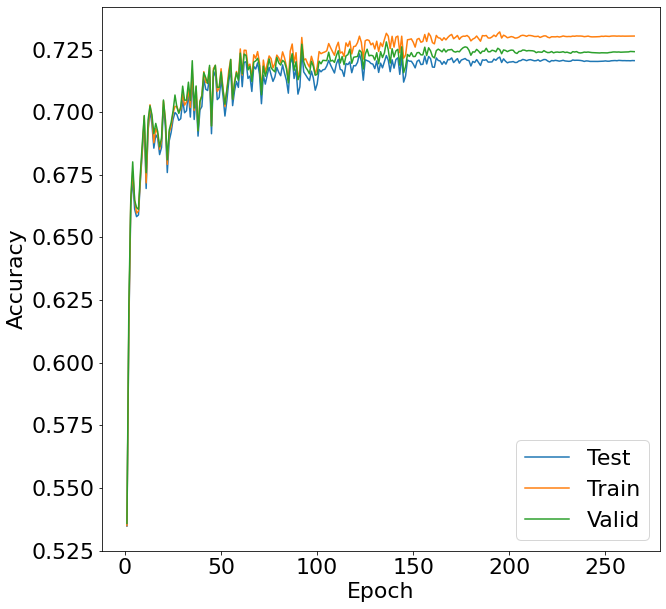

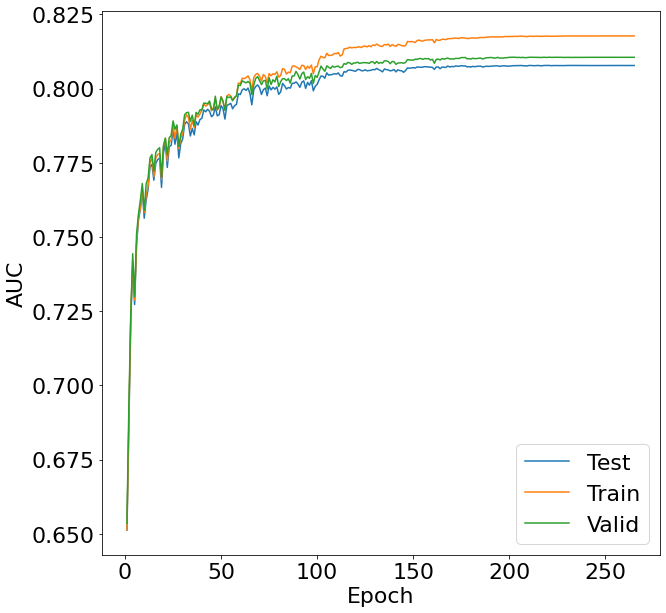

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('logs/metrics.pickle', 'rb') as handle:
    metric_logger = pickle.load(handle)

#Plot training/valid/testing metrics
for metric in set([_.split('/')[0] for _ in metric_logger.keys()]):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 22})
    epochs = len(metric_logger[metric+'/Test'])
    if 'Loss' in metric: 
        for label in ['/Test', '/Train', '/Valid']:
            metric_logger[metric+label] = [_.cpu() for _ in metric_logger[metric+label]]
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Test'], label='Test')
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Train'], label='Train')
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Valid'], label='Valid')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    print(metric)
    print('Number of Epochs {}: Testing {:.4f}, Training {:.4f}, Valid {:.4f}'.format(epochs, metric_logger[metric+'/Test'][-1], metric_logger[metric+'/Train'][-1], metric_logger[metric+'/Valid'][-1]))
    
print('Best Test AUC achieved at Epoch {}: {:.4f}'.format(np.argmax(metric_logger['AUC/Test'])+1, max(metric_logger['AUC/Test'])))
print('Test AUC achieved at last Epoch: {:.4f}'.format(metric_logger['AUC/Test'][-1]))